<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
     <td align="left"; style="background-color:transparent; width: 33%;"><a href="http://www.math-evry.cnrs.fr/departement/doku.php?id=formation:master:m2ds"><img src="https://github.com/ramp-kits/scMARK_classification/raw/main/evry_logo.png" width="65%"></a></td>
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/DATAIA-h.png" width="80%"></a></td>
    <td align="right"; style="background-color:transparent; width: 33%;"><a href="https://www.inrae.fr"><img src="https://www.inrae.fr/themes/custom/inrae_socle/logo.svg" width="40%"></a></td>
  </tr>
</table> 
</div>


<center><h1>Single-cell RNA-seq classification</h1></center>

<center><h3>A RAMP data-challenge on the prediction of cellular types based on genes expression level </h3></center>

<center><h2>Data Saiyentist - Modelization </h2></center>

# Setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

# Shape of the data
print("Dimension of X_train :", X_train.shape)
print("Dimension of X_test :", X_test.shape)

Dimension of X_train : (1000, 13551)
Dimension of X_test : (500, 13551)


# Preprocessing

**First, we preprocess the dataset as presented in the jupyter notebook `preprocess.ipynb` :**

In [2]:
%%time

def preprocess_X(X_sparse, y=None, rm_gene=None):
    # cast a dense array
    X = X_sparse.toarray()
    
    # compute call rates and remove genes and cells
    if y is not None:
        call_rate = X.mean(axis=1)
        X = X[call_rate>0.01, :]
        y = y[call_rate>0.01]                
        call_rate = X.mean(axis=0)
        X = X[:, call_rate>0.1]    
        
        return X / X.sum(axis=1)[:, np.newaxis], y, np.where(call_rate>0.1)[0]
    
    X = X[:, rm_gene]

    # normalize each row
    return X / X.sum(axis=1)[:, np.newaxis]

X_train, y_train, idx_gene = preprocess_X(X_train, y_train)
X_test = preprocess_X(X_test, rm_gene=idx_gene)

# Shape of the data after quality control, feature selection and normalization
print("Dimension of X_train :", X_train.shape)
print("Dimension of X_test :", X_test.shape)

Dimension of X_train : (1000, 4273)
Dimension of X_test : (500, 4273)
CPU times: total: 62.5 ms
Wall time: 74.1 ms


**And lower, you have an additional preprocessing step executed from a pipeline :**

In [3]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

process_pipe = Pipeline(
    [
        ("Scaler", StandardScaler()),
        ("VarianceThreshold", VarianceThreshold(threshold=0.1)),
        ("SelectKBest", SelectKBest(f_classif, k=1000)),
    ]
)

# fit and transform on train
process_pipe.fit(X_train, y_train)
X_train = process_pipe.transform(X_train)

# transform on test
X_test = process_pipe.transform(X_test)

# Shape of the data after feature selection and normalization
print("Dimension of X_train :", X_train.shape)
print("Dimension of X_test :", X_test.shape)

process_pipe

Dimension of X_train : (1000, 1000)
Dimension of X_test : (500, 1000)
CPU times: total: 141 ms
Wall time: 404 ms


Pipeline(steps=[('Scaler', StandardScaler()),
                ('VarianceThreshold', VarianceThreshold(threshold=0.1)),
                ('SelectKBest', SelectKBest(k=1000))])

# Modelization

**Then, we implement some ML models and compute the related balanced accuracy and other useful metrics :**

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

**As you may see below, we will test SVC, KNN, RandomForest, GradientBoosting and MLPC.**  
**Besides, here you have an example of how we performed an automated hyperparametrization of models. Actually, in this grid search, we are looking for the best MLP architecture knowing that we have 1000 features :**

In [5]:
%%time
from utils import search_param

param_grid = {
    'hidden_layer_sizes': [(1000, 1000), (1000, 1000, 1000), (2056, 2056)],
}

search_param(X_train, X_test, y_train, y_test, MLPClassifier(), param_grid)

{'hidden_layer_sizes': (2056, 2056)}
Train: 1.0
Test: 0.8213577318015839
CPU times: total: 20min 17s
Wall time: 9min 52s


In [7]:
# Classification models with best parameters
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, class_weight="balanced"),
    "SVM": SVC(C=10, kernel="linear", probability=True),
    "KNN": KNeighborsClassifier(leaf_size=5, n_neighbors=3),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_features="sqrt"),
    "MLP": MLPClassifier(hidden_layer_sizes=(1000, 1000)),
}

## Evaluation

**We will evaluate our models on the test dataset. But we can before that look at the distribution of our labels with t-SNE :**

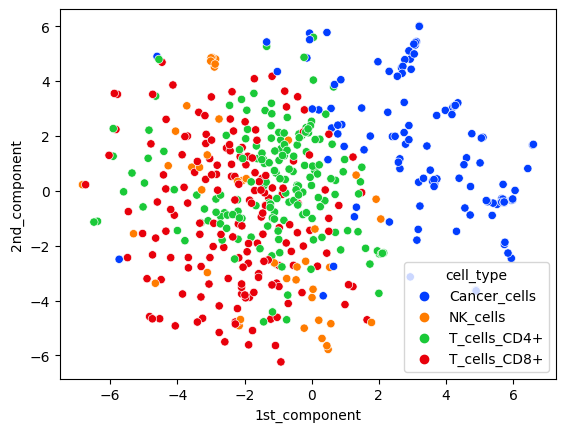

In [12]:
from utils import plot_tsne

plot_tsne(X_test, y_test)

=======Random Forest=======
Random Forest Accuracy: 0.75


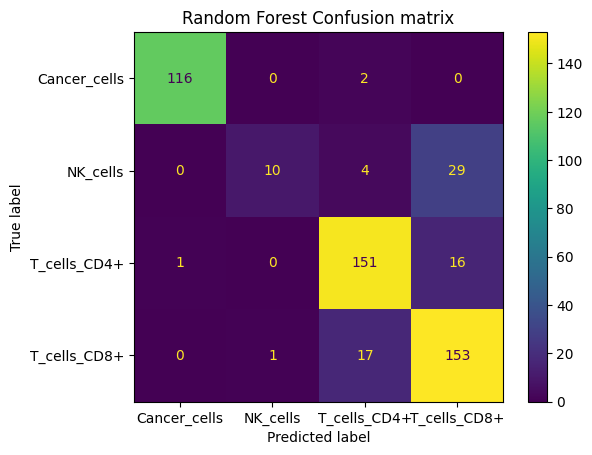

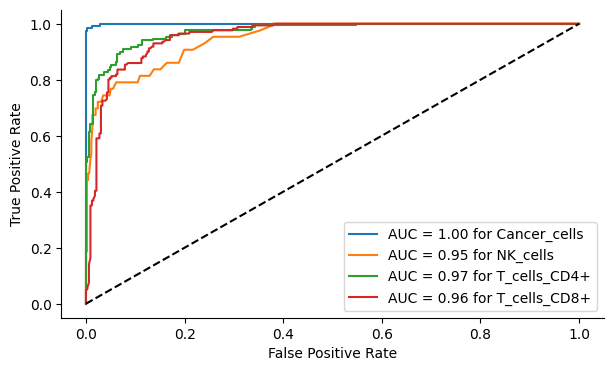

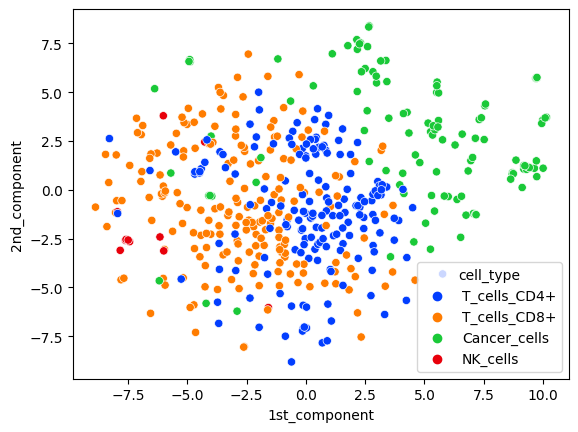

=======SVM=======
SVM Accuracy: 0.80


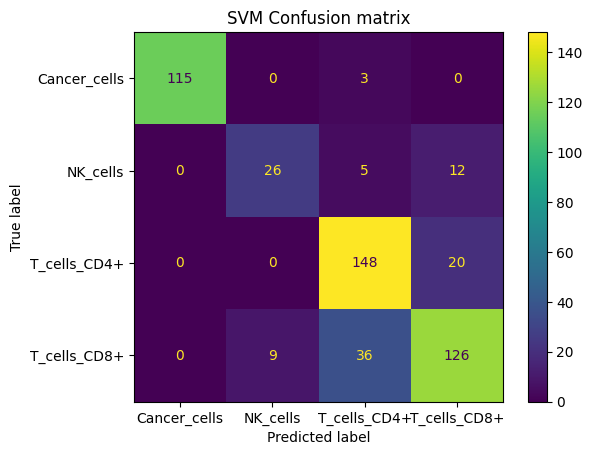

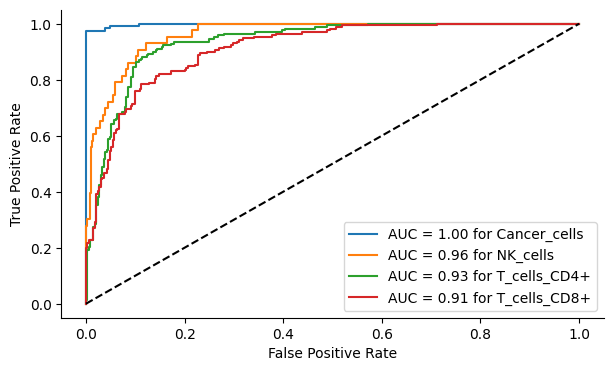

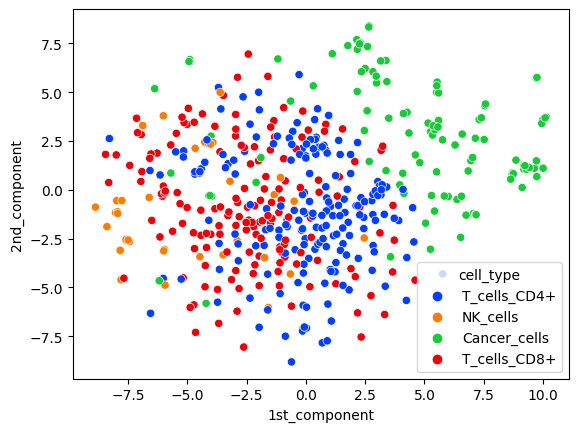

=======KNN=======
KNN Accuracy: 0.61


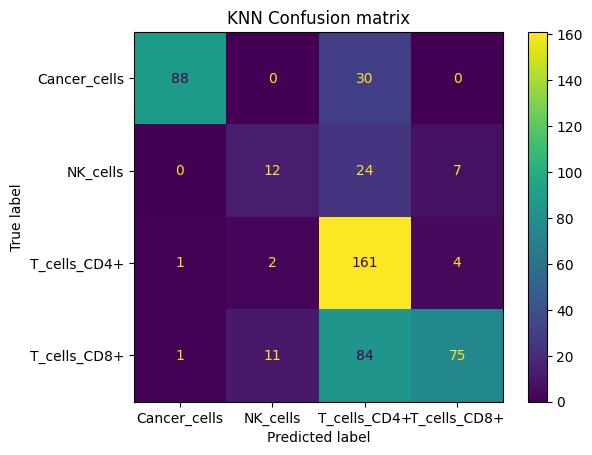

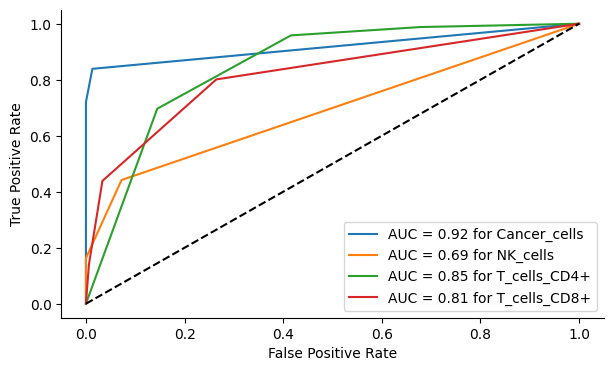

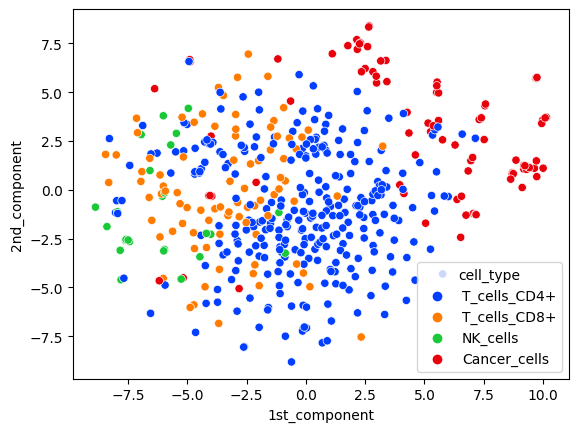

=======Gradient Boosting=======
Gradient Boosting Accuracy: 0.80


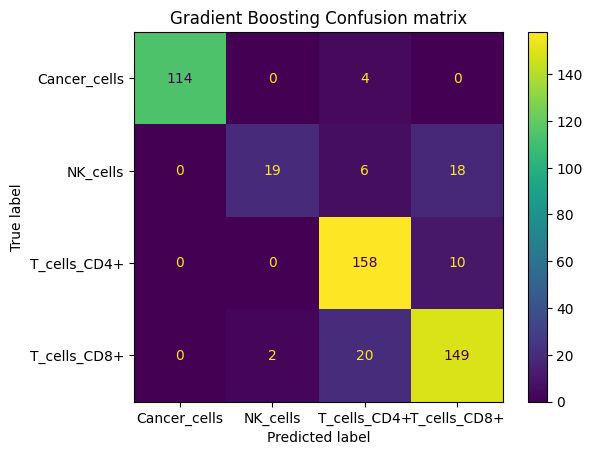

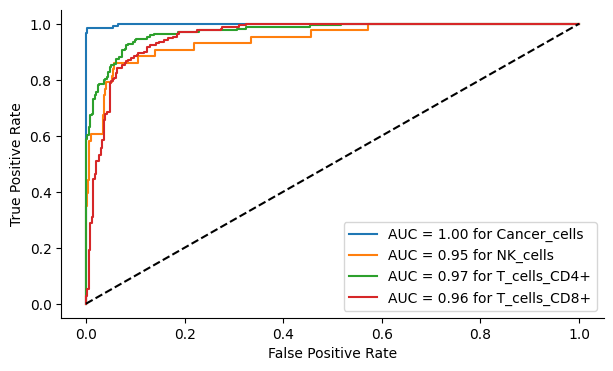

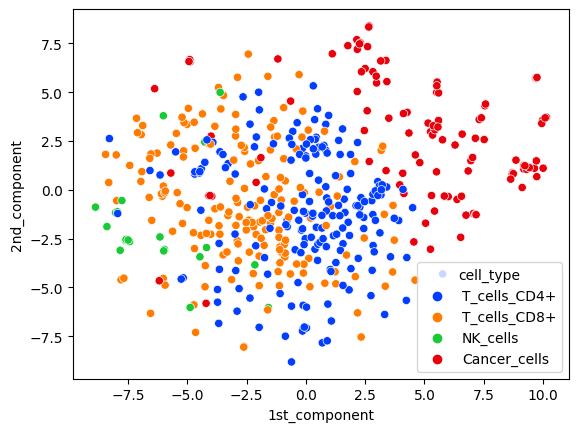

=======MLP=======
MLP Accuracy: 0.83


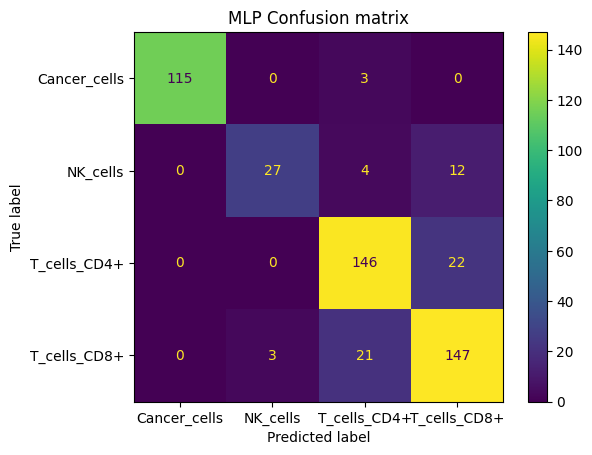

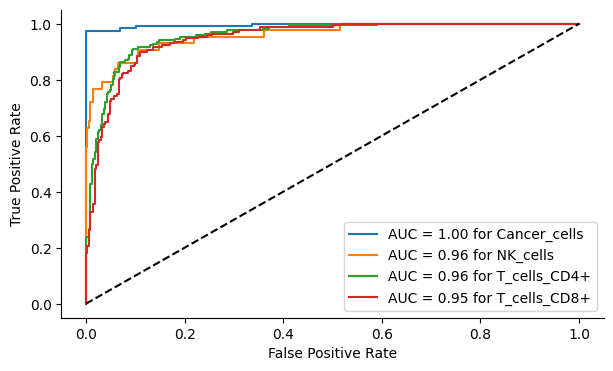

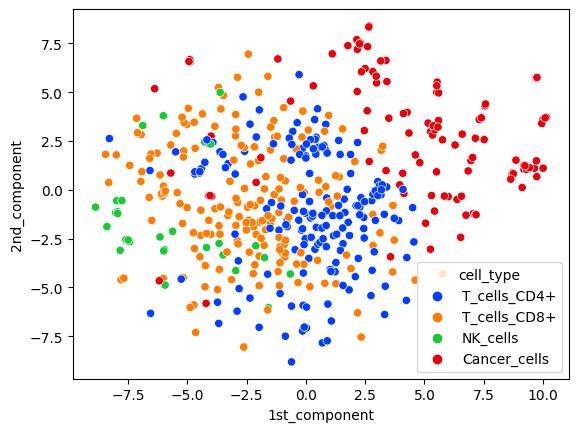

CPU times: total: 1min 17s
Wall time: 17.7 s


In [8]:
%%time
from utils import evaluate_model

# Model training and evaluation
for name, model in models.items():
    print(f"======={name}=======")
    evaluate_model(X_train, X_test, y_train, y_test, model, name)

**Most of our models have a reasonable balanced accuracy whereas it may be tough to distinguish `T_cells_CD4+` and `T_cells_CD8+`.**

**Next, we will test some tricks such as one-vs-rest or one-vs-all approach :**

=======OVR-SVM=======
OVR-SVM Accuracy: 0.79


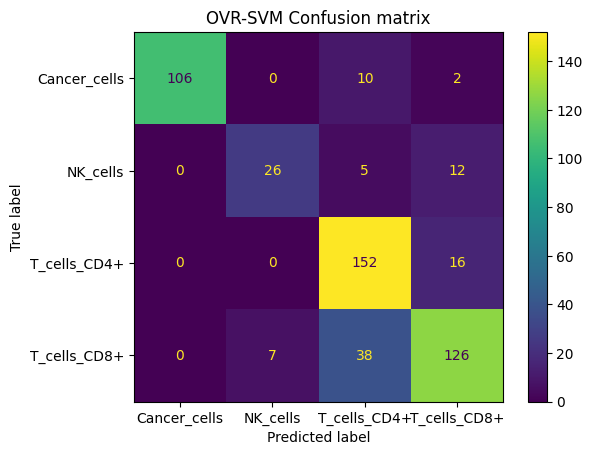

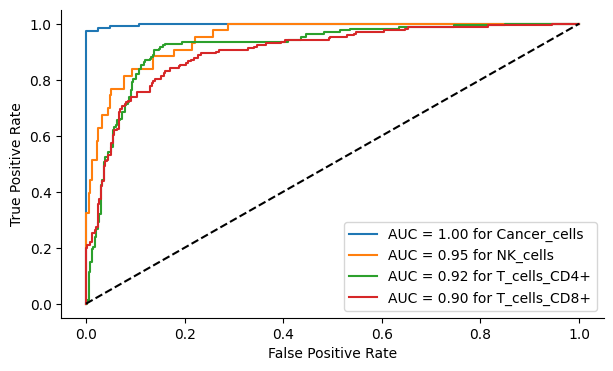

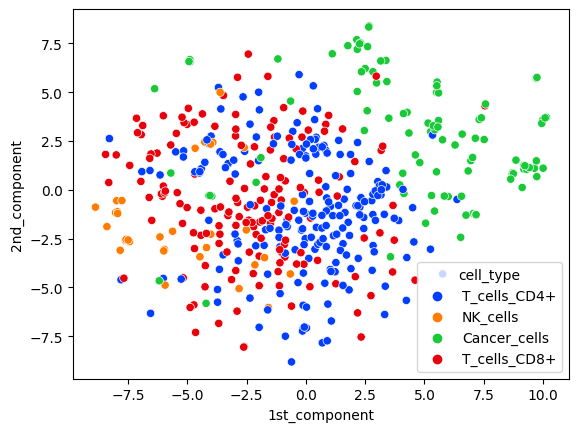

=======OVO-SVM=======
OVO-SVM Accuracy: 0.79
CPU times: total: 19.4 s
Wall time: 3.94 s


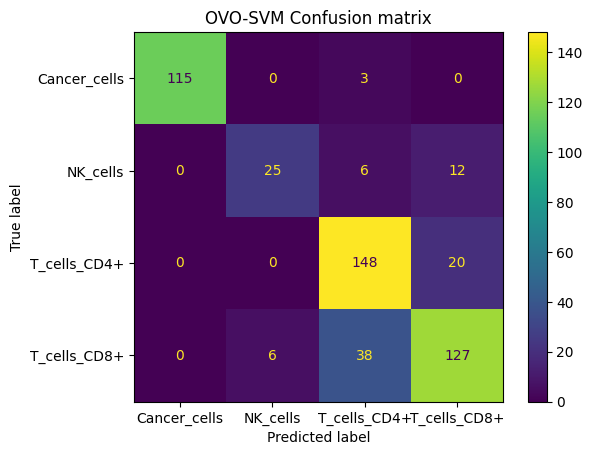

<Figure size 700x400 with 0 Axes>

In [13]:
%%time
models = {
    "OVR-SVM": OneVsRestClassifier(SVC(C = 10, kernel = "linear", probability=True)),
    "OVO-SVM": OneVsOneClassifier(SVC(C = 10, kernel = "linear", probability=True))
}

# SVC(C=10, kernel="linear", probability=True)

from utils import evaluate_model

# Model training and evaluation
for name, model in models.items():
    print(f"======={name}=======")
    try:
        evaluate_model(X_train, X_test, y_train, y_test, model, name)
    except Exception:
        pass

**Well, it seems that this will not increase model performances. Yet, we observe that SVM is one of the best model to classify correctly `NK_cells`.**  
**So we should trust this model to classify them. Then maybe consider another model to classify better the rest.**

## Model properties

**We will now look at their properties and compare them thanks to a (stratified) K-fold cross-validation given by the train dataset :**

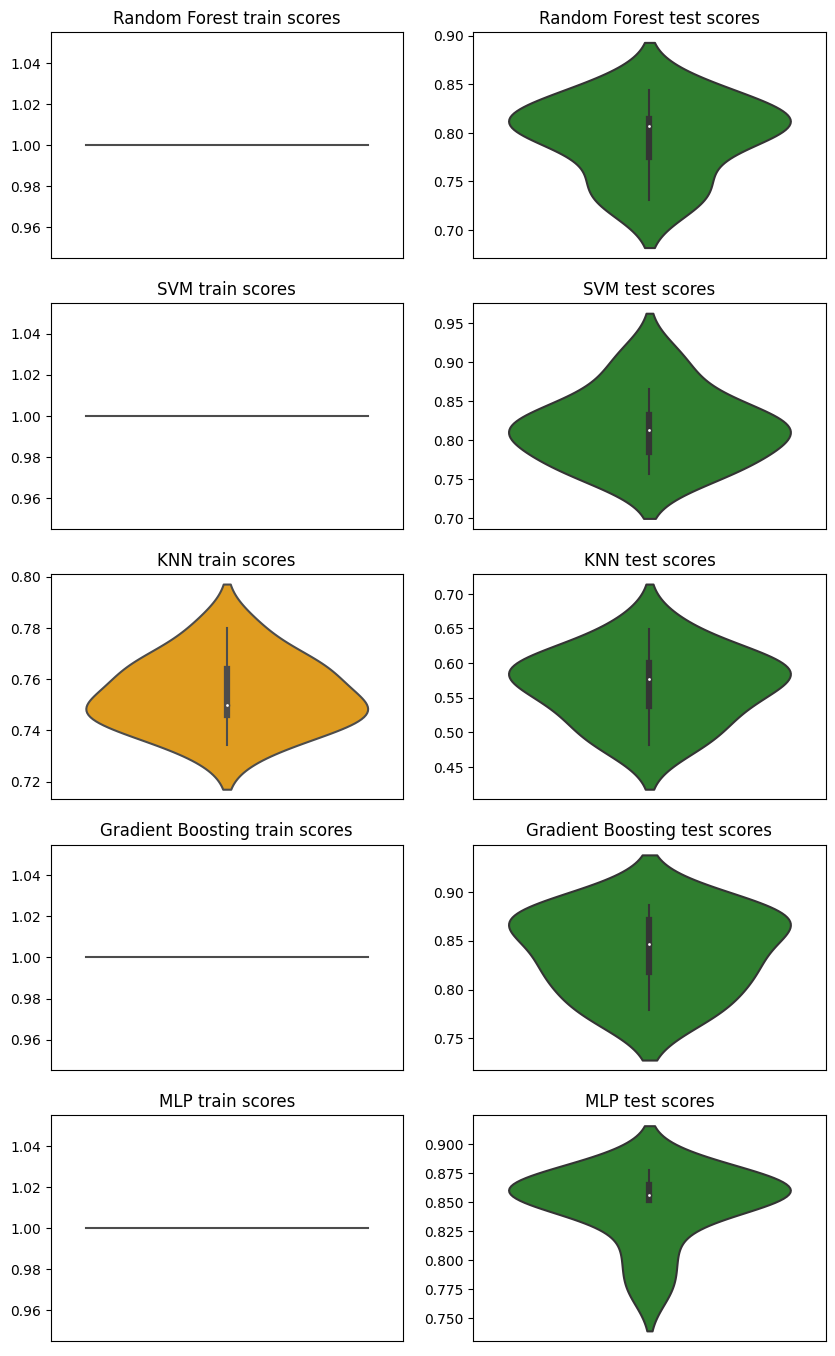

CPU times: total: 1min 8s
Wall time: 1min 35s


In [6]:
%%time
from utils import validate_model

validate_model(X_train, y_train, models)

**We notice overfitting most of the time, but only SVM seems stable (and sometimes it overperforms its competitors). And MLPC should not be trusted too much because of its performance. In fact, we can see that sometimes MLPC can underperform a lot.**

**But thanks to this K-fold cross validation, we can definitely say that KNN is not that powerful with our classification problem.**